In [2]:
# Part 1 - Import Required Libraries
# Here, we import pandas for data manipulation, sklearn for machine learning tasks,
# seaborn and matplotlib for data visualization, and numpy for numerical operations.
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from scipy import interp


In [3]:
# Part 2 - Load and Combine Datasets
# The data from separate CSV files for Opel Corsa (two journeys) and Peugeot 207 (two journeys) are loaded.
opel_corsa_01 = pd.read_csv('opel_corsa_01.csv', sep=';', decimal=',')
opel_corsa_02 = pd.read_csv('opel_corsa_02.csv', sep=';', decimal=',')
peugeot_207_01 = pd.read_csv('peugeot_207_01.csv', sep=';', decimal=',')
peugeot_207_02 = pd.read_csv('peugeot_207_02.csv', sep=';', decimal=',')

# After loading, the datasets are concatenated into a single DataFrame 'combined_df' for unified processing.
combined_df = pd.concat([opel_corsa_01, opel_corsa_02, peugeot_207_01, peugeot_207_02], ignore_index=True)


# Display the first few rows of the combined dataset and summary information
combined_df_info = combined_df.info()
combined_df_head = combined_df.head()

combined_df_info, combined_df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23775 entries, 0 to 23774
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 23775 non-null  int64 
 1   AltitudeVariation          23775 non-null  object
 2   VehicleSpeedInstantaneous  23766 non-null  object
 3   VehicleSpeedAverage        23775 non-null  object
 4   VehicleSpeedVariance       23775 non-null  object
 5   VehicleSpeedVariation      23775 non-null  object
 6   LongitudinalAcceleration   23775 non-null  object
 7   EngineLoad                 23770 non-null  object
 8   EngineCoolantTemperature   23770 non-null  object
 9   ManifoldAbsolutePressure   23770 non-null  object
 10  EngineRPM                  23770 non-null  object
 11  MassAirFlow                23770 non-null  object
 12  IntakeAirTemperature       23770 non-null  object
 13  VerticalAcceleration       23775 non-null  object
 14  FuelCo

(None,
    Unnamed: 0    AltitudeVariation VehicleSpeedInstantaneous  \
 0          59           -2.2999878               25.67051888   
 1          60           -2.0999756               24.09425926   
 2          61                 -1.5               22.74317932   
 3          62            0.1000366               22.29281998   
 4          63  0.09997560000000001               23.64389992   
 
   VehicleSpeedAverage VehicleSpeedVariance VehicleSpeedVariation  \
 0         13.22350089   121.59268970000001   -2.4769802000000003   
 1         13.63891915          120.4225707           -1.57625962   
 2         14.03104293          118.4567689           -1.35107994   
 3         14.17107305          117.5713084           -0.45035934   
 4          14.3289535          117.0741485            1.35107994   
 
   LongitudinalAcceleration   EngineLoad EngineCoolantTemperature  \
 0                   0.3555  4.705882549                       68   
 1                   0.4492  10.58823586       

In [4]:
# Part 3 - Data Preprocessing and Cleaning
# Convert columns with numeric data represented as strings to appropriate numeric types
numeric_cols = ['AltitudeVariation', 'VehicleSpeedInstantaneous', 'VehicleSpeedAverage', 
                'VehicleSpeedVariance', 'VehicleSpeedVariation', 'LongitudinalAcceleration', 
                'EngineLoad', 'EngineCoolantTemperature', 'ManifoldAbsolutePressure', 'EngineRPM', 
                'MassAirFlow', 'IntakeAirTemperature', 'VerticalAcceleration', 'FuelConsumptionAverage']

# Calculate the median for numeric columns to handle missing data
numeric_medians = combined_df[numeric_cols].median()

# Now fill missing values with the median of their respective columns
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(numeric_medians)

# Recheck the DataFrame information to ensure the numeric conversion and filling operation were successful.
combined_df_info_after_filling = combined_df.info()
combined_df_head_after_filling = combined_df.head()

combined_df_info_after_filling, combined_df_head_after_filling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23775 entries, 0 to 23774
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 23775 non-null  int64 
 1   AltitudeVariation          23775 non-null  object
 2   VehicleSpeedInstantaneous  23775 non-null  object
 3   VehicleSpeedAverage        23775 non-null  object
 4   VehicleSpeedVariance       23775 non-null  object
 5   VehicleSpeedVariation      23775 non-null  object
 6   LongitudinalAcceleration   23775 non-null  object
 7   EngineLoad                 23775 non-null  object
 8   EngineCoolantTemperature   23775 non-null  object
 9   ManifoldAbsolutePressure   23775 non-null  object
 10  EngineRPM                  23775 non-null  object
 11  MassAirFlow                23775 non-null  object
 12  IntakeAirTemperature       23775 non-null  object
 13  VerticalAcceleration       23775 non-null  object
 14  FuelCo

(None,
    Unnamed: 0    AltitudeVariation VehicleSpeedInstantaneous  \
 0          59           -2.2999878               25.67051888   
 1          60           -2.0999756               24.09425926   
 2          61                 -1.5               22.74317932   
 3          62            0.1000366               22.29281998   
 4          63  0.09997560000000001               23.64389992   
 
   VehicleSpeedAverage VehicleSpeedVariance VehicleSpeedVariation  \
 0         13.22350089   121.59268970000001   -2.4769802000000003   
 1         13.63891915          120.4225707           -1.57625962   
 2         14.03104293          118.4567689           -1.35107994   
 3         14.17107305          117.5713084           -0.45035934   
 4          14.3289535          117.0741485            1.35107994   
 
   LongitudinalAcceleration   EngineLoad EngineCoolantTemperature  \
 0                   0.3555  4.705882549                       68   
 1                   0.4492  10.58823586       

AltitudeVariation            float64
VehicleSpeedInstantaneous    float64
VehicleSpeedAverage          float64
VehicleSpeedVariance         float64
VehicleSpeedVariation        float64
LongitudinalAcceleration     float64
EngineLoad                   float64
EngineCoolantTemperature     float64
ManifoldAbsolutePressure     float64
EngineRPM                    float64
MassAirFlow                  float64
IntakeAirTemperature         float64
VerticalAcceleration         float64
FuelConsumptionAverage       float64
dtype: object


c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

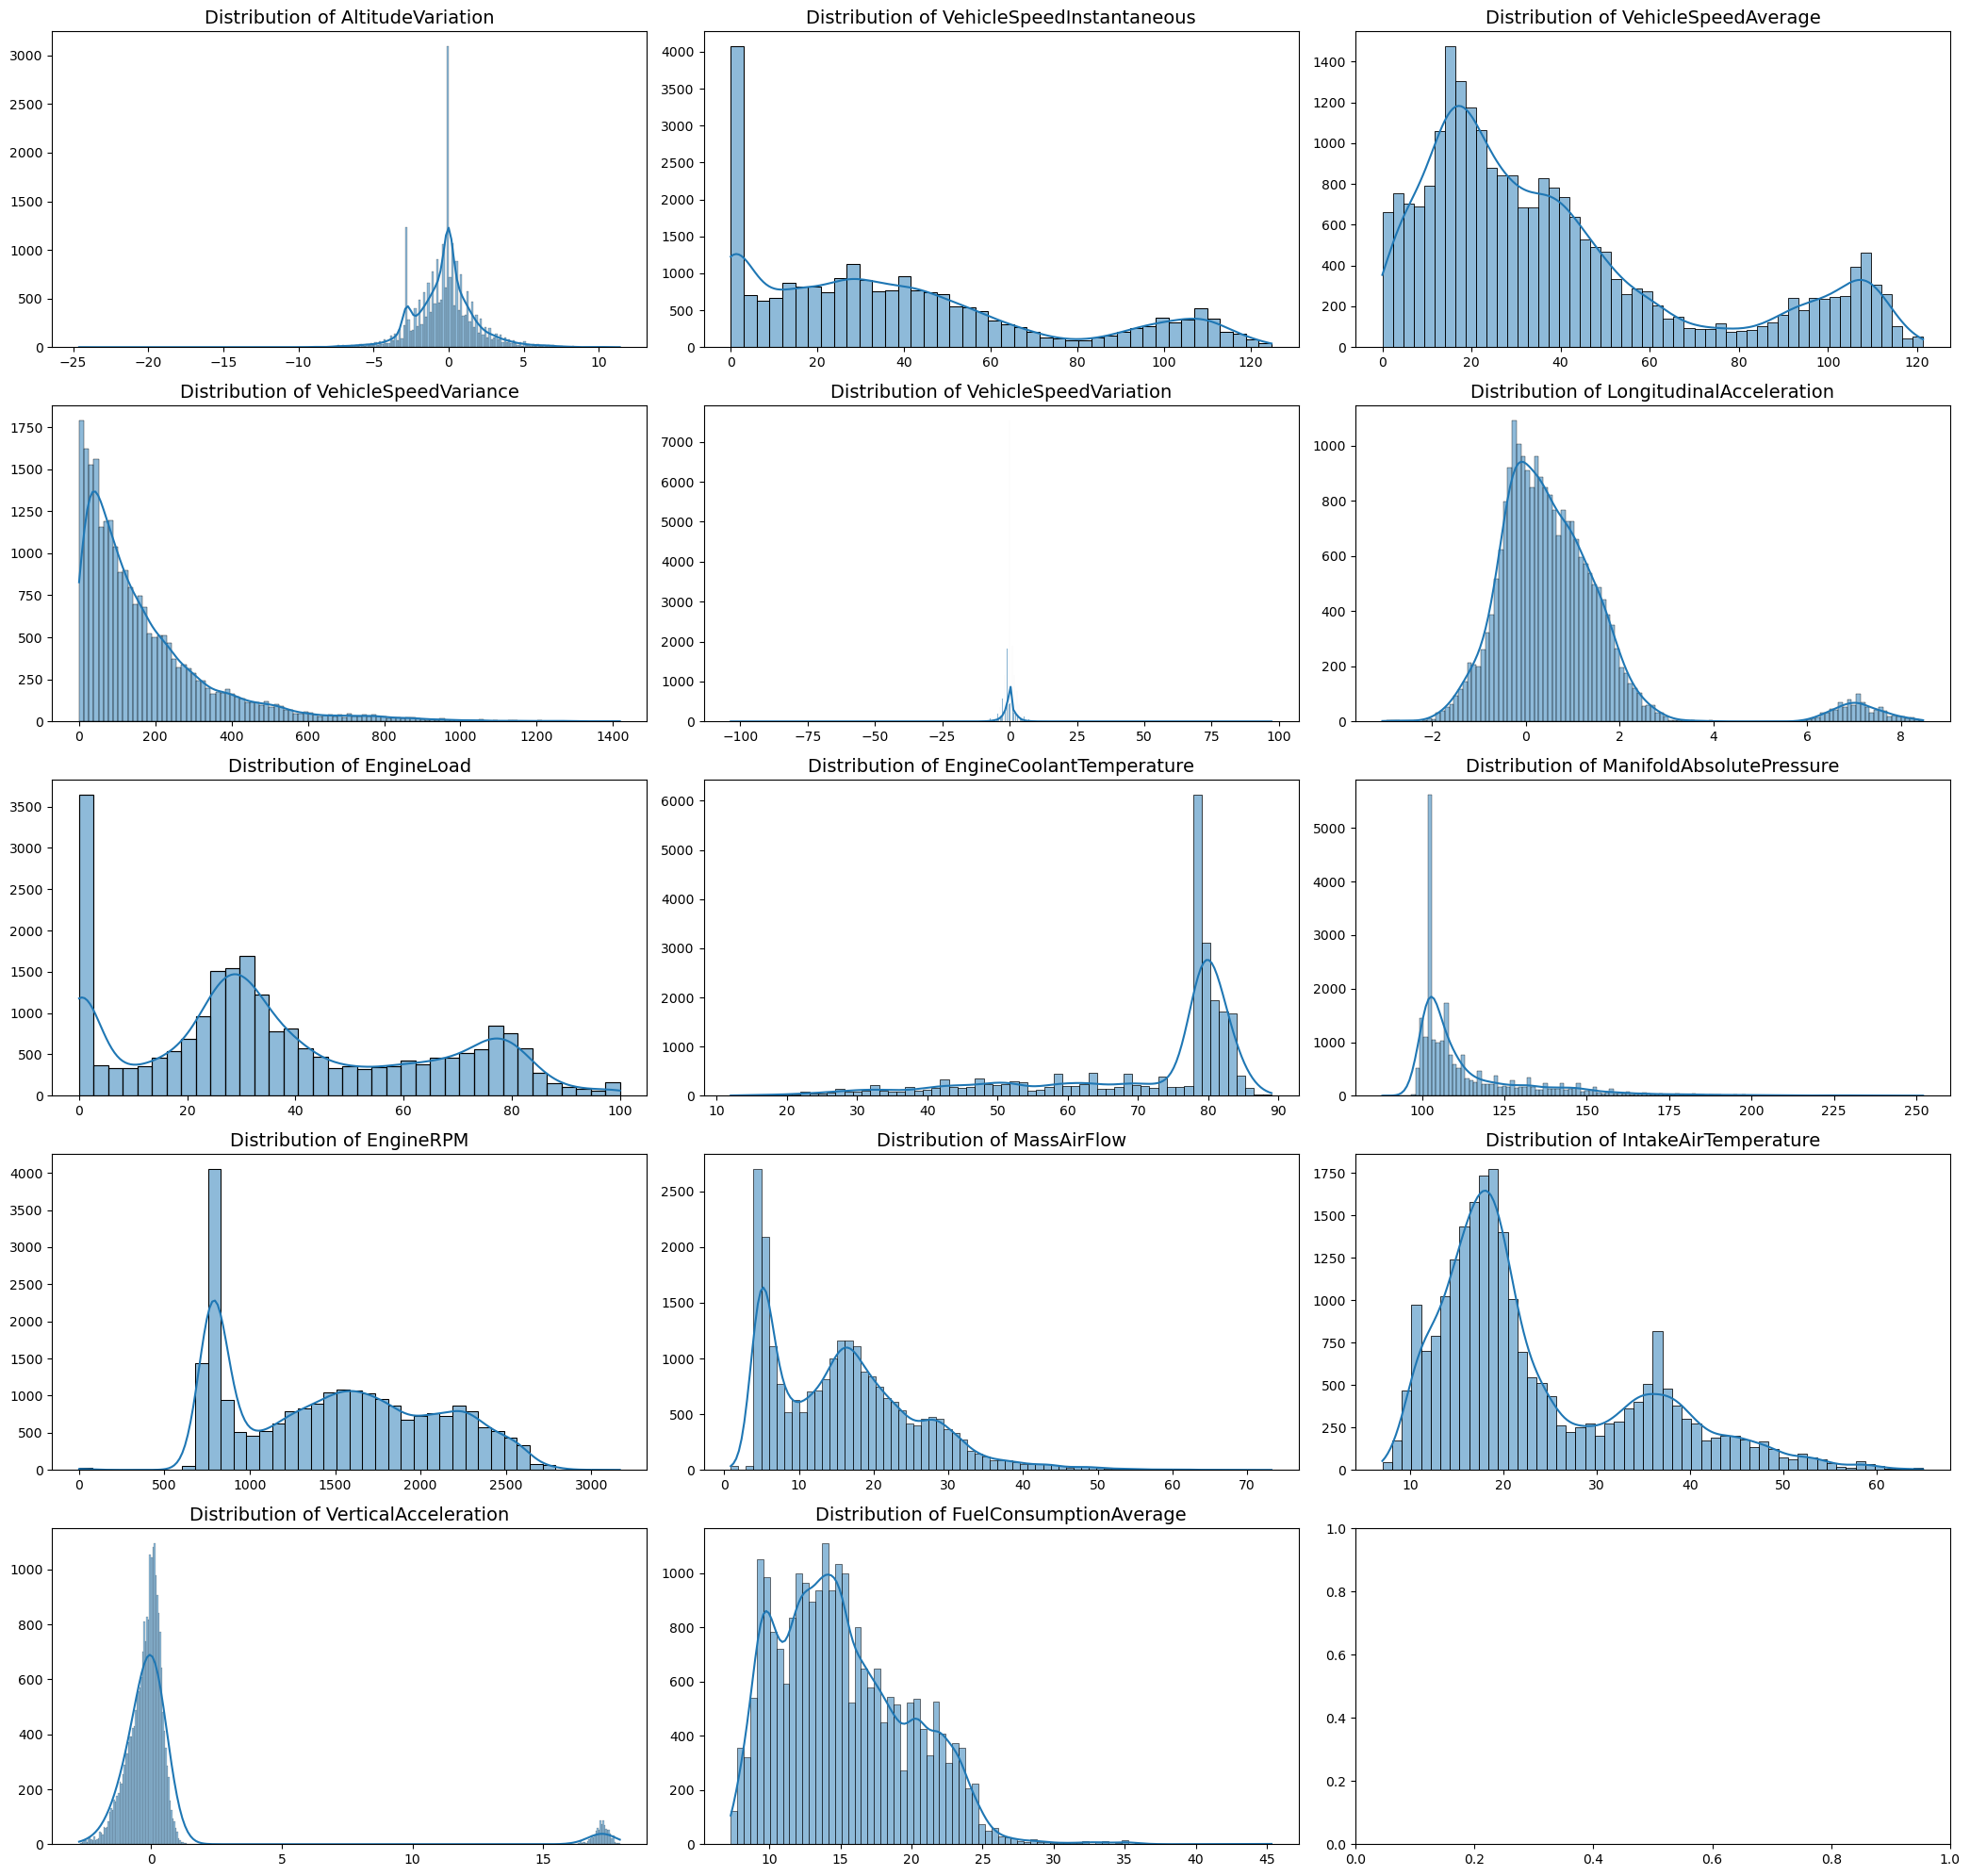

In [5]:
# Part 3.1 - Data Distribution Visualisations After Preprocessing
# After cleaning the data, visualize the distribution of each feature.
# Histograms with kernel density estimation provide insight into the spread and skewness of the data distributions.
features_for_visualization = combined_df.drop(columns=['traffic', 'Unnamed: 0', 'roadSurface', 'drivingStyle']).columns
# Calculate the number of rows needed for subplots based on the number of features.
n_rows = (len(features_for_visualization) + 2) // 3
fig, axs = plt.subplots(n_rows, 3, figsize=(21, n_rows * 4))
axs = axs.flatten()

# Convert features to numeric types to ensure compatibility with histogram plotting.
combined_df[features_for_visualization] = combined_df[features_for_visualization].apply(pd.to_numeric, errors='coerce')

# Check the data types again
print(combined_df[features_for_visualization].dtypes)

# Generate the histograms and set the titles and labels for each subplot.
for i, feature in enumerate(features_for_visualization):
    sns.histplot(data=combined_df, x=feature, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}', fontsize=14)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()

In [7]:
# Part 4 - Encoding Categorical Data for Machine Learning

# Initialize a label encoder for the target column 'traffic'
label_encoder = LabelEncoder()

# The LabelEncoder converts categorical labels into a numeric form
combined_df['traffic_encoded'] = label_encoder.fit_transform(combined_df['traffic'])

# Store the mapping of original categorical labels to their encoded numeric form for reference.
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Drop the original 'traffic' column as we now have an encoded version
combined_df = combined_df.drop('traffic', axis=1)

# Display the mapping and the first few rows to confirm the change
class_mapping, combined_df.head()

({'HighCongestionCondition': 0,
  'LowCongestionCondition': 1,
  'NormalCongestionCondition': 2},
    Unnamed: 0  AltitudeVariation  VehicleSpeedInstantaneous  \
 0          59          -2.299988                  25.670519   
 1          60          -2.099976                  24.094259   
 2          61          -1.500000                  22.743179   
 3          62           0.100037                  22.292820   
 4          63           0.099976                  23.643900   
 
    VehicleSpeedAverage  VehicleSpeedVariance  VehicleSpeedVariation  \
 0            13.223501            121.592690              -2.476980   
 1            13.638919            120.422571              -1.576260   
 2            14.031043            118.456769              -1.351080   
 3            14.171073            117.571308              -0.450359   
 4            14.328954            117.074149               1.351080   
 
    LongitudinalAcceleration  EngineLoad  EngineCoolantTemperature  \
 0          

VehicleSpeedAverage          0.131568
EngineCoolantTemperature     0.126380
FuelConsumptionAverage       0.103913
VehicleSpeedVariance         0.098571
IntakeAirTemperature         0.095976
EngineRPM                    0.079925
LongitudinalAcceleration     0.075065
ManifoldAbsolutePressure     0.060131
VehicleSpeedInstantaneous    0.053979
VerticalAcceleration         0.053428
MassAirFlow                  0.045692
EngineLoad                   0.031551
AltitudeVariation            0.027359
VehicleSpeedVariation        0.016463
dtype: float64


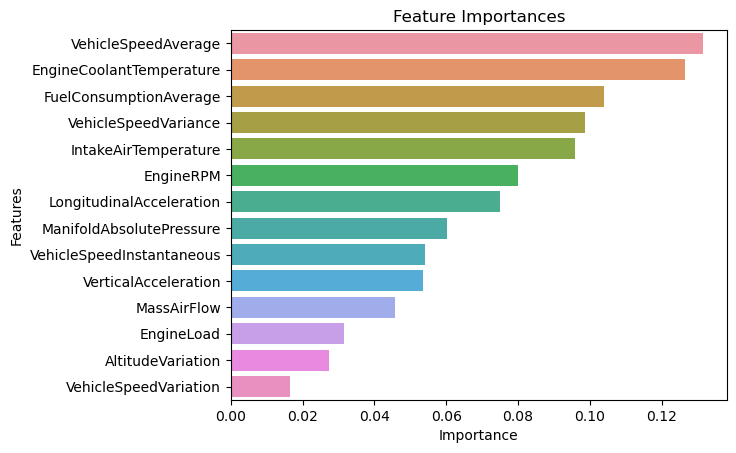

In [9]:
# Part 5 - Feature Importance Evaluation with Random Forest

# Prepare the features (X) and the target variable (y)
X = combined_df.drop(columns=['traffic_encoded', 'Unnamed: 0', 'roadSurface', 'drivingStyle'])
y = combined_df['traffic_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
rf.fit(X_train, y_train)

# Extract feature importances from the Random Forest and sort them for better interpretability.
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Print and visualize the feature importances to understand the impact of each feature on the model.
print(sorted_feature_importances)
sns.barplot(x=sorted_feature_importances.values, y=sorted_feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png')
plt.show()

In [10]:
# Part 6 - Balancing the Dataset with SMOTE
# Since machine learning models perform better on balanced datasets, use SMOTE to oversample minority classes.
X = combined_df.drop(columns=['traffic_encoded', 'Unnamed: 0', 'roadSurface', 'drivingStyle'])
y = combined_df['traffic_encoded']

# Standardize features to have a mean of 0 and a standard deviation of 1, which is important for models like kNN.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the standardized data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Apply SMOTE only on the training data to prevent information leakage into the test set.
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution after resampling to verify the balancing process.
print(pd.Series(y_resampled).value_counts())

traffic_encoded
1    12434
2    12434
0    12434
Name: count, dtype: int64


In [ ]:
# Part 7 -  Finding the best hyperparameters for the kNNN classifier
# Reason for doing this is that it seems like the prediction is not good enough as it predicts the most for class 1.
# Even though the best paramter is 1, it is not the best for the model as it is overfitting. It seems like 5 is the best parameter for the model so were trading some accuracy for generalization.
# Set up the parameter grid for k
param_grid = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}

# Initialize the kNN classifier
knn = KNeighborsClassifier()

# Configure grid search with cross-validation to evaluate all possible combinations of parameters in the grid.
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# Perform the grid search on the resampled training data.
knn_gscv.fit(X_resampled, y_resampled)

# Print the best parameters and the best score
print("Best Parameters: ", knn_gscv.best_params_)
print("Best Score: ", knn_gscv.best_score_)

# Use the best hyperparameters found to fit the kNN model and predict the test set outcomes.
knn_best = knn_gscv.best_estimator_
y_pred = knn_best.predict(X_test)

In [11]:
# Part 8 - Training and Evaluating Classifier Models
# Prepare classifiers, including SVM and Logistic Regression, ensuring sufficient iterations for convergence.
# The classifiers will be trained on the balanced dataset and evaluated using cross-validation for consistent comparison.

# Instantiate classifier objects with hyperparameters aimed to ensure model convergence.
svm_clf = LinearSVC(random_state=42, dual=False, max_iter=5000)
logreg_clf = LogisticRegression(random_state=42, max_iter=5000)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Store the probability predictions for each classifier
prob_predictions = {}


# Loop through the classifier instances to train and evaluate each.
for clf, name in zip([svm_clf, logreg_clf, knn_clf], ['Linear SVM', 'Logistic Regression', 'kNN']):
    # Evaluate the classifier using cross-validation on the resampled training set for a robust accuracy estimate.
    scores = cross_val_score(clf, X_resampled, y_resampled, cv=5)
    print(f'{name} Accuracy: {scores.mean():.2f} ')
    
    # Fit the model on the resampled training data
    clf.fit(X_resampled, y_resampled)
    
    # Predict on the original test set, not resampled
    y_pred = clf.predict(X_test)

    # If the classifier supports probability predictions, store them
    if hasattr(clf, "predict_proba"):
        prob_predictions[name] = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):  # SVM will fall in this category
        # SVM decision function needs to be converted to probabilities if you want to use it for ROC
        prob_predictions[name] = clf.decision_function(X_test)
    
    # Generate and print a classification report to evaluate precision, recall, and F1-score for each class.
    print(pd.Series(y_pred).value_counts())

    print(f'\nClassification Report for {name}:\n', classification_report(y_test, y_pred))


Linear SVM Accuracy: 0.63 
1    3706
0    1934
2    1493
Name: count, dtype: int64

Classification Report for Linear SVM:
               precision    recall  f1-score   support

           0       0.37      0.80      0.51       906
           1       0.91      0.63      0.75      5330
           2       0.27      0.45      0.34       897

    accuracy                           0.63      7133
   macro avg       0.52      0.63      0.53      7133
weighted avg       0.76      0.63      0.67      7133

Logistic Regression Accuracy: 0.64 
1    3646
2    1755
0    1732
Name: count, dtype: int64

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.40      0.77      0.53       906
           1       0.92      0.63      0.75      5330
           2       0.26      0.51      0.34       897

    accuracy                           0.63      7133
   macro avg       0.53      0.63      0.54      7133
weighted avg       0.77      

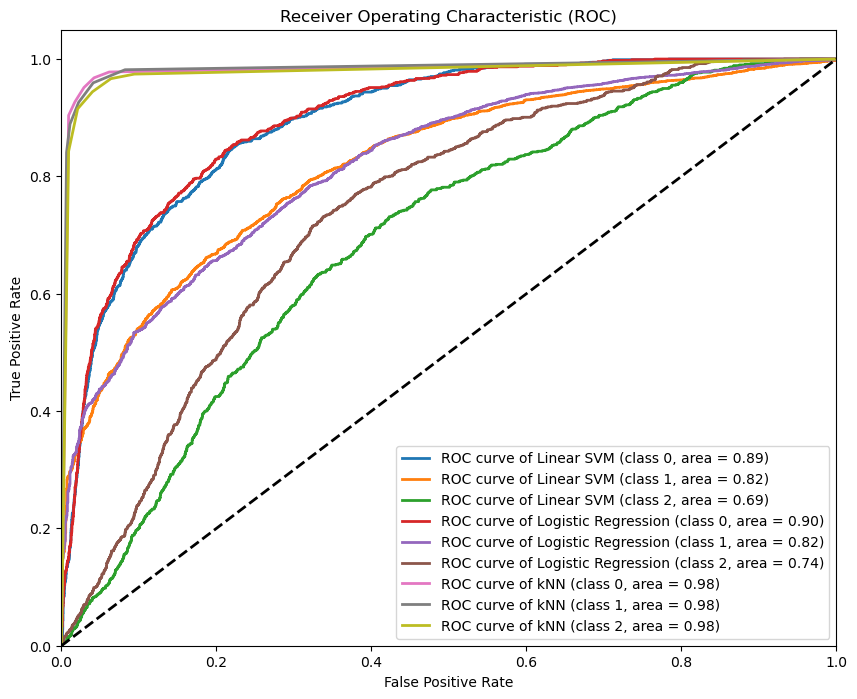

In [13]:
# Part 8.1 - ROC Curves and AUC for Multi-Class Classification
# For multi-class classification tasks, each class's ROC curve and AUC are calculated individually.
# The process involves binarizing the output and then using One-vs-Rest (OvR) strategy to compute the metrics.

# Convert the multi-class labels into a binary format that is suitable for ROC curve computation.
y_test_binarized = label_binarize(y_test, classes=np.unique(y_resampled))
n_classes = y_test_binarized.shape[1] # Determine the number of classes

# Plot the ROC curve for each classifier
plt.figure(figsize=(10, 8))

for name, y_pred_proba in prob_predictions.items():
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        if name == 'Linear SVM':  # SVM requires special handling
            # Convert decision scores to probabilities if necessary
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot all ROC curves
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of {name} (class {i}, area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()
